# Conditional Logic Demo

Read accumulated I and Q data from accumulated readout buffer and conditionally trigger a different pulse if 'I' exceeds some threshold.

Readout needs alignment with DAC pulse. This is achieved by changing the `adc_trig_offset` parameter of `trigger()`.

DAC_A and ADC_C are in loopback for these programs. DAC_B is used to monitor the latency of the conditional logic evaluation.

The current minimum delay between the end of the initial pulse (aligned with readout) and the beginning of the conditional pulse is ~440ns.

![](images/conditional_logic_capture.png)

In [3]:
# Import libraries
%load_ext autoreload
%autoreload 2

%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [54]:
class ConditionalPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        length_us = 0.05
        freq_mhz = 200
        freq = self.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

        for ch in range(2):
            self.declare_gen(ch=ch, nqz=1)
  
        gen_length = self.us2cycles(length_us, gen_ch=1)
        for ch in range(2):
            self.set_pulse_registers(ch=ch, freq=freq, style="const", phase=0, gain=20000, length=gen_length)


        ro_length = self.us2cycles(length_us-0.001, ro_ch=1)
        self.ro_length = ro_length
        self.declare_readout(ch=1, freq=freq_mhz, length=ro_length, phase=0 ,gen_ch=1)

        self.synci(100) 
    
    def body(self):
        self.pulse(ch=1, t=0) # Pulse DAC_A
        self.pulse(ch=0, t=0) # Pulse DAC_B
        self.trigger(adcs=[1], adc_trig_offset=0) # Trigger ADC_C readout at t=0+adc_trig_offset
        
        self.wait_all(35) # Wait until end of readout + 35 tproc cycles

        self.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        self.read(1, 0, "upper", 2) #              "             Q into page 0, reg 2
        self.memwi(0, 1, 123) # Write accumulated I into memory location 123
        self.memwi(0, 2, 124) #         "         Q           "          124
        
        self.condj(0, 1, '<', 0, "JUMP_LOC") # Compare stored accumulated I with value stored in 0 register (ie. 0)
        self.pulse(ch=0) # Pulse DAC_B if no jump
        self.label("JUMP_LOC")

In [55]:
# Configure program
config={"reps": 1}
prog = ConditionalPulse(soccfg, config)

In [ ]:
# Reset generators if pulses currently playing
soc.reset_gens()

I and Q values read from tproc input: [6, 14]
sum of I and Q in decimated buffer: [6.0, 14.0]


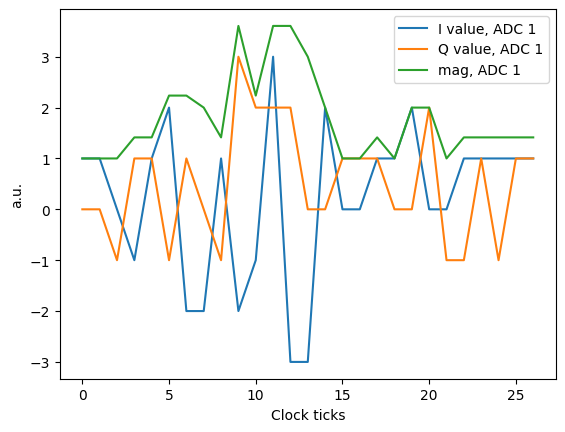

In [58]:
# Acquire decimated method - retrieve decimated data from buffer
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("sum of I and Q in decimated buffer:", [sum(iq) for iq in iq_list[0]])

# Plot results.
plt.figure(1)
iq = iq_list[0]
plt.plot(iq[0], label="I value, ADC %d"%(1))
plt.plot(iq[1], label="Q value, ADC %d"%(1))
plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(1))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend();

In [62]:
# Acquire method - retrieve summed data from buffer
iq_list = prog.acquire(soc, load_pulses=True, progress=True)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("I and Q values in accumulated buffer:", [iq[0]*prog.ro_length for iq in iq_list])

  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [18, 6]
I and Q values in accumulated buffer: [array([18.]), array([6.])]


In [3562]:
# As before, but without AveragerProgram wrapper
prog = QickProgram(soccfg)

freq_mhz = 200
length_us = 0.05
gain = 10000

for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)

freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
gen_length = prog.us2cycles(length_us, gen_ch=1)
for ch in range(2):
    prog.set_pulse_registers(ch=ch, freq=freq, style="const", phase=0, 
                            gain=gain, length=gen_length)

ro_length = prog.us2cycles(length_us, ro_ch=1)
prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

prog.synci(100) 
    
prog.trigger(adcs=[1], adc_trig_offset=132) # Trigger ADC_C readout at t=0+adc_trig_offset
prog.pulse(ch=1) # Pulse DAC_A
prog.pulse(ch=0) # Pulse DAC_B

prog.wait_all(35) # Wait until end of readout + 35 tproc cycles

prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
prog.read(1, 0, "upper", 2) #              "             Q into page 0, reg 2
prog.memwi(0, 1, 123) # Write accumulated I into memory location 123
prog.memwi(0, 2, 124) #         "         Q           "          124

prog.condj(0, 1, '>', 0, "JUMP_LOC") # Compare stored accumulated I with value stored in 0 register (ie. 0)
prog.pulse(ch=0) # Pulse DAC_B if no jump
prog.label("JUMP_LOC")
prog.end()

prog.config_all(soc) # Load the assembly onto the board
soc.tproc.start() # Start tproc program execution

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)

I and Q values read from tproc input: [-362, -2920]
